In [2]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import gridspec
import ast
import json
import seaborn as sn


PREPROCESSED_CLASSES = ['BitTorrent', 'Cridex', 'FTP', 'Geodo', 'Gmail', 'Htbot', 'Miuref', 'Neris', 'Nsis-ay', 'Outlook', 'SMB', 'Virut', 'Weibo', 'WorldOfWarcraft']
PREPROCESSED_CLASSES_NERIS_VIRUT = ['BitTorrent', 'Cridex', 'FTP', 'Geodo', 'Gmail', 'Htbot', 'Miuref', 'Neris/Virut', 'Nsis-ay', 'Outlook', 'SMB', 'Weibo', 'WorldOfWarcraft']

PAYLOAD_CLASSES = ['BitTorrent', 'Cridex', 'FTP', 'Gmail', 'Htbot', 'Neris', 'Nsis-ay', 'Outlook', 'SMB', 'Shifu', 'Virut', 'Weibo']
PAYLOAD_CLASSES_NERIS_VIRUT = ['BitTorrent', 'Cridex', 'FTP', 'Gmail', 'Htbot', 'Neris/Virut', 'Nsis-ay', 'Outlook', 'SMB', 'Shifu', 'Weibo']
BINARY_CLASSES = ['Benign', 'Malware']

# Standard loss plots for one training task (model dataset combination)

In [48]:
#csv_files = ["/home/manuel/Bachelorarbeit/results/ray_results/best_results/progress_next.csv"] 
csv_files = ["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/resnet-50/next_nerisvirut/scores1.csv"] 
train_losses = []
val_losses = []


for file in csv_files:
    if file.endswith(".csv"):
        df = pd.read_csv(file)
        train_losses += df["training-losses"].to_list()
        val_losses += df["loss"].to_list()
        
n_val_epochs = len(val_losses)
val_epochs = range(1, n_val_epochs+1)
# since we save multiple train losses per epoch our csv contains list strings 
train_losses = [ast.literal_eval(t) for t in train_losses]
# we only want to print the train loss at the end of the epoch
train_losses = [sublist[-1] for sublist in train_losses]
n_train_epochs = len(train_losses)
train_epochs = range(1, n_train_epochs+1)
max_lim = 0.65 if ("multiclass" in csv_files[0] or "progress" in csv_files[0]) else 0.055


outliers_train = [val for val in train_losses if val > max_lim]
outliers_val = [val for val in val_losses if val > max_lim]
outliers = outliers_train + outliers_val

plt.rcParams.update({'font.size': 17})
x_size = max(n_train_epochs/4, 3)
fig = plt.figure(figsize=(x_size, 8))
if outliers:
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.3, 0.7])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    fig.subplots_adjust(hspace=0.05)
    max_outlier = max(outliers)
    min_outlier = min(outliers)
    ax1.set_ylim(min_outlier - min_outlier*0.2, max_outlier + max_outlier*0.2)

    if "multiclass" in csv_files[0] or "progress" in csv_files[0]: 
        ax2.set_yticks(np.arange(0.0, 0.7, 0.1))
        ax2.set_ylim(0.0, max_lim)
    else:
        ax2.set_yticks(np.arange(0.0, 0.055, 0.005))
        ax2.set_ylim(0.0, max_lim)
    ax1.plot(train_epochs, train_losses, marker='x', label="Training Set")
    ax2.plot(train_epochs, train_losses, marker='x', label="Training Set")
    ax1.plot(val_epochs, val_losses, marker='x', label="Validation Set")
    ax2.plot(val_epochs, val_losses, marker='x', label="Validation Set")
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,
        labelbottom=False)
    ax2.xaxis.tick_bottom()
    kwargs = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    ax2.set_ylabel('Loss')
    if "multiclass" in csv_files[0] or "progress" in csv_files[0]: 
        ax2.yaxis.set_label_coords(0.047, 0.5, transform=fig.transFigure)
    else:
        ax2.yaxis.set_label_coords(0.044, 0.5, transform=fig.transFigure)
    fig.tight_layout()
    
else:
    plt.plot(train_epochs, train_losses, marker='x', label="Training Set")
    plt.plot(val_epochs, val_losses, marker='x', label="Validation Set")
    if "multiclass" in csv_files[0] or "progress" in csv_files[0]: 
        plt.yticks(np.arange(0.0, 0.7, 0.1))
        plt.ylim(0.0, max_lim)
    else:
        plt.yticks(np.arange(0.0, 0.055, 0.005))
        plt.ylim(0.0, max_lim)
    
    plt.ylabel("Loss")
    

plt.xticks(range(0,n_train_epochs+1, 5))
plt.xlabel("Epoch")
plt.tight_layout()
loc = "upper right"
if n_val_epochs <= 17:
    pass
    loc = (0.6, 0.7)
if outliers:
    ax1.legend(loc=loc)
else:
    plt.legend(loc=loc)

plt.savefig("val_train_loss.svg", format="svg")

plt.clf()

<Figure size 400x800 with 0 Axes>

# Accuracy and F1-Comparison 

In [37]:
#multiclass
#payload
csv_files = [["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/vgg-19/notop/scores1.csv"], [ "/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/vgg-19/fc/scores1.csv"], ["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/resnet-50/resnet/scores1.csv"], ["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/resnet-50/next/scores1.csv"]]
#payload accum
#csv_files = [["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/vgg-19/notop_nerisvirut/scores1.csv"], [ "/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/vgg-19/fc_nerisvirut/scores1.csv"], ["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/resnet-50/resnet_nerisvirut/scores1.csv"], ["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/resnet-50/next_nerisvirut/scores1.csv"]]
#preprocessed
#csv_files = [["/home/manuel/Bachelorarbeit/results/ray_results/best_results/progress_notop.csv", "/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/notop/scores24.csv"], ["/home/manuel/Bachelorarbeit/results/ray_results/best_results/progress_fc.csv", "/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/fc/scores24.csv"], ["/home/manuel/Bachelorarbeit/results/ray_results/best_results/progress_resnet.csv"], ["/home/manuel/Bachelorarbeit/results/ray_results/best_results/progress_next.csv"]]
#preprocessed accum 
#csv_files = [["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/notop_nerisvirut/scores1.csv"], [ "/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/fc_nerisvirut/scores1.csv"], ["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/resnet-50/resnet_nerisvirut/scores1.csv"], ["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/resnet-50/next_nerisvirut/scores1.csv"]]
#binary
#preprocessed
#csv_files = [["/home/manuel/Bachelorarbeit/results/saved_models-new/binary/preprocessed/vgg-19/notop/scores1.csv"],["/home/manuel/Bachelorarbeit/results/saved_models-new/binary/preprocessed/vgg-19/fc/scores1.csv"],["/home/manuel/Bachelorarbeit/results/saved_models-new/binary/preprocessed/resnet-50/resnet/scores1.csv"],["/home/manuel/Bachelorarbeit/results/saved_models-new/binary/preprocessed/resnet-50/next/scores1.csv"]]
#payload
#csv_files = [["/home/manuel/Bachelorarbeit/results/saved_models-new/binary/payload/vgg-19/notop/scores1.csv"],["/home/manuel/Bachelorarbeit/results/saved_models-new/binary/payload/vgg-19/fc/scores1.csv"],["/home/manuel/Bachelorarbeit/results/saved_models-new/binary/payload/resnet-50/resnet/scores1.csv"],["/home/manuel/Bachelorarbeit/results/saved_models-new/binary/payload/resnet-50/next/scores1.csv"]]
models = ["VGG-Notop", "VGG-Fully-Connected", "Resnet", "ResneXt"]

accuracies_per_model = [[],[],[],[]]
f1_per_model = [[],[],[],[]]

for idx, files in enumerate(csv_files):
    for file in files:
        if file.endswith(".csv"):
            df = pd.read_csv(file)
            # Training loss will be tracked during the whole training process
            accuracies_per_model[idx] += df["accuracy"].to_list()
            f1_per_model[idx] += df["macro-f1"].to_list()

outliers_accuracy = []
outliers_f1 = []
n_train_epochs = 0
for accuracy_model in accuracies_per_model:
    n_train_epochs = max(n_train_epochs, len(accuracy_model))
    outliers_accuracy += [val*100 for val in accuracy_model if val < 0.68]
for f1_model in f1_per_model:
    outliers_f1 += [val*100 for val in f1_model if val < 0.68]

plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(n_train_epochs/4, 8))
x_size = max(n_train_epochs/4, 3)
if outliers_accuracy:
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.7, 0.3])
    fig = plt.figure(figsize=(x_size, 8))
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    fig.subplots_adjust(hspace=0.05)
    max_outlier = max(outliers_accuracy)
    min_outlier = min(outliers_accuracy)
    ax2.set_ylim(min_outlier - min_outlier*0.2, max_outlier + max_outlier*0.2)

    ax1.set_yticks(np.arange(70, 105, 5))
    ax1.set_ylim(68, 100)
    for j, model in enumerate(models):
        accuracies = [100* acc for acc in accuracies_per_model[j]]
        epochs = range(1, len(accuracies)+1)
        ax1.plot(epochs, accuracies, label=model, marker=".")
        ax2.plot(epochs, accuracies, label=model, marker=".")
    
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,
        labelbottom=False)
    ax2.xaxis.tick_bottom()
    kwargs = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    ax1.set_ylabel('Accuracy')
    ax1.yaxis.set_label_coords(0.047, 0.5, transform=fig.transFigure)
    fig.tight_layout()

else:
    for j, model in enumerate(models):
        accuracies = [100* acc for acc in accuracies_per_model[j]]
        epochs = range(1, len(accuracies)+1)
        plt.plot(epochs, accuracies, label=model, marker=".")
    
    plt.yticks(range(70, 105, 5))
    plt.ylim(68,100)
    plt.ylabel("Accuracy")
    plt.tight_layout()


plt.xlabel("Epoch")
plt.tight_layout()
plt.legend(loc='lower right')
plt.savefig("Accuracy_comparison.svg", format="SVG")
plt.clf()

plt.figure(figsize=(n_train_epochs/4, 8))
x_size = max(n_train_epochs/4, 3)
if outliers_f1:
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.7, 0.3])
    fig = plt.figure(figsize=(x_size, 8))
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    fig.subplots_adjust(hspace=0.05)
    max_outlier = max(outliers_f1)
    min_outlier = min(outliers_f1)
    ax2.set_ylim(min_outlier - min_outlier*0.2, max_outlier + max_outlier*0.2)

    ax1.set_yticks(np.arange(70, 105, 5))
    ax1.set_ylim(68, 100)
    for j, model in enumerate(models):
        f1_scores = [100*f for f in f1_per_model[j]]
        epochs = range(1, len(f1_scores)+1)
        ax1.plot(epochs, f1_scores, label=model, marker=".")
        ax2.plot(epochs, f1_scores, label=model, marker=".")
    
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,
        labelbottom=False)
    ax2.xaxis.tick_bottom()
    kwargs = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    ax1.set_ylabel("Macro-F1")
    ax1.yaxis.set_label_coords(0.047, 0.5, transform=fig.transFigure)
    fig.tight_layout()

else:
    for j, model in enumerate(models):
        f1_scores = [100*f for f in f1_per_model[j]]
        epochs = range(1, len(f1_scores)+1)
        plt.plot(epochs, f1_scores, label=model, marker=".")
    
    plt.yticks(range(70, 105, 5))
    plt.ylim(68,100)
    plt.ylabel("Macro-F1")
    plt.tight_layout()


plt.xlabel("Epoch")
plt.tight_layout()
plt.legend(loc='lower right')
plt.savefig("F1_comparison.svg", format="SVG")
plt.clf()

<Figure size 550x800 with 0 Axes>

<Figure size 550x800 with 0 Axes>

<Figure size 550x800 with 0 Axes>

<Figure size 550x800 with 0 Axes>

# ROC Curve


# multiclass

In [17]:
roc = torch.load("/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/fc/roc.pt")
fpr = roc[0]
tpr = roc[1]
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(fpr))))
for label in range(len(fpr)):
    fpr_label = fpr[label].tolist()
    tpr_label = tpr[label].tolist()
    plt.plot(fpr_label, tpr_label, color = next(color), label = "class " + str(label))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.savefig("ROC.svg", format="svg")
plt.clf()


<Figure size 640x480 with 0 Axes>

# binary


In [18]:
roc = torch.load("/home/manuel/Bachelorarbeit/results/saved_models-new/binary/payload/vgg-19/fc/roc.pt")
fpr = roc[0]
tpr = roc[1]
plt.plot(fpr, tpr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC.svg", format="svg")
plt.clf()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

# Histogram of prediction distribution

# binary

In [85]:
distribution_json = '/home/manuel/Bachelorarbeit/results/saved_models-new/binary/payload/vgg-19/fc/bonus_scores.json'

with open(distribution_json, 'r') as f:
  distribution_dict = json.load(f)["Label_prediction_distribution"]


probabilities_Benign = distribution_dict["0"]
probabilities_Malware = distribution_dict["1"]

probabilities = probabilities_Benign + probabilities_Malware
total_instances_label = len(probabilities)
    
q3, q1 = np.percentile(probabilities, [75 ,25])
iqr = q3 - q1
bin_width = (2 * iqr) / np.power(total_instances_label, 1/3)

n_bins_Benign = round((max(probabilities_Benign) - min(probabilities_Benign)) / bin_width)
n_bins_Malware = round((max(probabilities_Malware) - min(probabilities_Malware)) / bin_width)
n_bins_Benign = max(n_bins_Benign, 1)
n_bins_Malware = max(n_bins_Malware, 1)
n_bins_Benign = min(n_bins_Benign, 30)
n_bins_Malware = min(n_bins_Malware, 30)

plt.rcParams.update({'font.size': 17})
plt.hist(probabilities_Benign, bins=n_bins_Benign, label="Benign", weights=np.ones(len(probabilities_Benign)) / len(probabilities_Benign),
          alpha=0.5, color="green")
plt.hist(probabilities_Malware, bins=n_bins_Malware, label="Malware", weights=np.ones(len(probabilities_Malware)) / len(probabilities_Malware),
          alpha=0.5, color="red")

plt.yscale("log")
plt.yticks([0.0001, 0.001, 0.01, 0.1, 1.0])
plt.ylim((0.00005,1.2))
plt.ylabel('Fraction of instances')
plt.xlabel('Sigmoid output by Model')
plt.legend(loc="upper center")
plt.tight_layout()
plt.savefig("histogram.svg", format="svg")
plt.clf()


4.644659293341539e-05
30
30


<Figure size 640x480 with 0 Axes>

# Confusion Matrix

Multiclass


{'BitTorrent': 0.0, 'Cridex': 0.0, 'FTP': 0.0, 'Geodo': 0.001863932898415657, 'Gmail': 0.008333333333333333, 'Htbot': 0.033084311632870865, 'Miuref': 0.005249343832020997, 'Neris/Virut': 0.02451539338654504, 'Nsis-ay': 0.03273809523809524, 'Outlook': 0.020390070921985817, 'SMB': 0.0, 'Weibo': 0.0, 'WorldOfWarcraft': 0.0}
{'BitTorrent': 0.0, 'Cridex': 0.0, 'FTP': 0.0, 'Geodo': 0.0018639328984156878, 'Gmail': 0.008333333333333304, 'Htbot': 0.033084311632870844, 'Miuref': 0.005249343832021025, 'Neris/Virut': 0.02451539338654507, 'Nsis-ay': 0.03273809523809523, 'Outlook': 0.02039007092198586, 'SMB': 0.0, 'Weibo': 0.0, 'WorldOfWarcraft': 0.0}


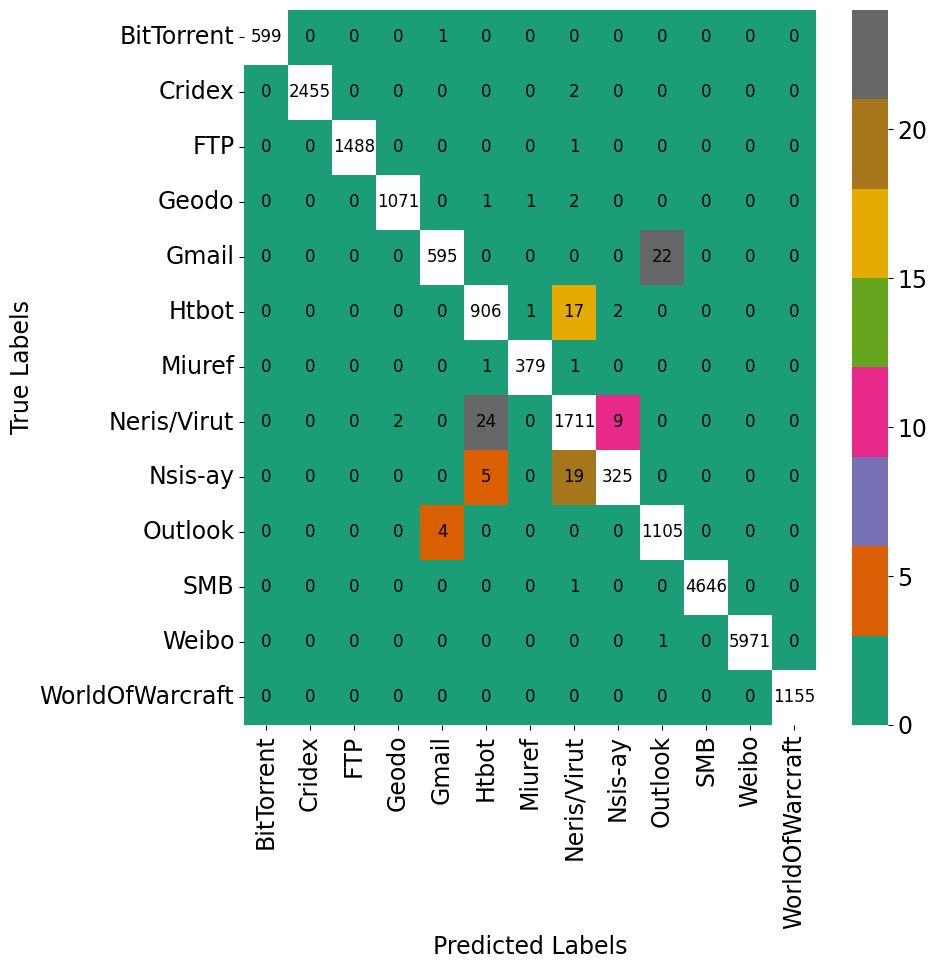

In [33]:
FDR_per_class = {}
FDR2_per_class = {}
cf_matrix = torch.load("/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/fc_nerisvirut/confusion_matrix.pt")
cf_matrix = cf_matrix.numpy()
df_cm = pd.DataFrame(cf_matrix,
                    columns = [i for i in PREPROCESSED_CLASSES_NERIS_VIRUT],
                    index=[i for i in PREPROCESSED_CLASSES_NERIS_VIRUT])

off_diag_mask = np.eye(*cf_matrix.shape, dtype=bool)

for class_idx, class_name in enumerate(df_cm.columns):
    class_predictions = df_cm[class_name]
    class_predictions = class_predictions.to_list()
    TP = class_predictions[class_idx]
    false_predictions = class_predictions[:class_idx] + class_predictions[class_idx+1:]
    FP =  np.sum(false_predictions)
    FDR = FP / (TP + FP)
    FDR2_per_class[class_name] = 1 - (TP / (TP+FP))
    FDR_per_class[class_name] = FDR

print(FDR_per_class)
print(FDR2_per_class)
plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(10,10))
sn.heatmap(df_cm, annot=True, fmt='g', mask=off_diag_mask, cmap="Dark2", annot_kws={"color": "k", "size": 12})
sn.heatmap(df_cm, fmt="g", alpha=0, mask=~off_diag_mask, cbar=False, annot=True, annot_kws={"color": "k", "size": 12})
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.savefig("Confusion.svg", format="svg", dpi = 400)

Binary


{'Benign': 6.414368184733804e-05, 'Malware': 0.0}
{'Benign': 6.414368184737285e-05, 'Malware': 0.0}


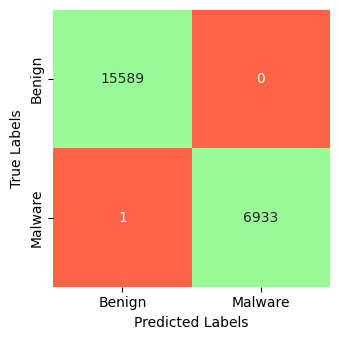

In [20]:
FDR_per_class = {}
FDR2_per_class = {}
cf_matrix = torch.load("/home/manuel/Bachelorarbeit/results/saved_models-new/binary/preprocessed/vgg-19/notop/confusion_matrix.pt")
cf_matrix = cf_matrix.numpy()
df_cm = pd.DataFrame(cf_matrix,
                    columns = [i for i in BINARY_CLASSES],
                    index=[i for i in BINARY_CLASSES])

for class_idx, class_name in enumerate(df_cm.columns):
    class_predictions = df_cm[class_name]
    class_predictions = class_predictions.to_list()
    TP = class_predictions[class_idx]
    false_predictions = class_predictions[:class_idx] + class_predictions[class_idx+1:]
    FP =  np.sum(false_predictions)
    FDR = FP / (TP + FP)
    FDR2_per_class[class_name] = 1 - (TP / (TP+FP))
    FDR_per_class[class_name] = FDR

print(FDR_per_class)
print(FDR2_per_class)
plt.figure(figsize=(3.5,3.5))
sn.heatmap(np.eye(2), annot=df_cm, fmt='g',
            cmap=sn.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
            yticklabels=BINARY_CLASSES, xticklabels=BINARY_CLASSES)
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.savefig("Confusion.svg", format="svg", dpi = 400)

# Scores to class

In [23]:
F1_per_label = [0.5276073619631901, 0.9995933306222042, 0.999466097170315, 0.8460431654676259, 0.9617097061442564, 0.7457627118644068, 0.9292196007259528, 0.8178466076696166, 0.9995696148052508, 1.0, 0.8322295805739514, 0.9996649355000837]
Recall_per_label = [0.35833333333333334, 1.0, 1.0, 0.7331670822942643, 0.9660107334525939, 0.7051282051282052, 0.9110320284697508, 1.0, 0.9995696148052508, 1.0, 0.868663594470046, 0.9994974874371859]
Precision_per_label = [1.0, 0.9991869918699187, 0.9989327641408752, 1.0, 0.9574468085106383, 0.7913669064748201, 0.9481481481481482, 0.6918278228321897, 0.9995696148052508, 1.0, 0.798728813559322, 0.9998324396782842]
print(list(zip(PAYLOAD_CLASSES, F1_per_label)))
print(list(zip(PAYLOAD_CLASSES, Recall_per_label)))
print(list(zip(PAYLOAD_CLASSES, Precision_per_label)))

[('BitTorrent', 0.5276073619631901), ('Cridex', 0.9995933306222042), ('FTP', 0.999466097170315), ('Gmail', 0.8460431654676259), ('Htbot', 0.9617097061442564), ('Neris', 0.7457627118644068), ('Nsis-ay', 0.9292196007259528), ('Outlook', 0.8178466076696166), ('SMB', 0.9995696148052508), ('Shifu', 1.0), ('Virut', 0.8322295805739514), ('Weibo', 0.9996649355000837)]
[('BitTorrent', 0.35833333333333334), ('Cridex', 1.0), ('FTP', 1.0), ('Gmail', 0.7331670822942643), ('Htbot', 0.9660107334525939), ('Neris', 0.7051282051282052), ('Nsis-ay', 0.9110320284697508), ('Outlook', 1.0), ('SMB', 0.9995696148052508), ('Shifu', 1.0), ('Virut', 0.868663594470046), ('Weibo', 0.9994974874371859)]
[('BitTorrent', 1.0), ('Cridex', 0.9991869918699187), ('FTP', 0.9989327641408752), ('Gmail', 1.0), ('Htbot', 0.9574468085106383), ('Neris', 0.7913669064748201), ('Nsis-ay', 0.9481481481481482), ('Outlook', 0.6918278228321897), ('SMB', 0.9995696148052508), ('Shifu', 1.0), ('Virut', 0.798728813559322), ('Weibo', 0.9998